In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
dataset_name = 'ravdess'
experiment_prefix = "scb14"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"

sr = 16000
batch_size = 4
in_channels = 1
kernel_size = 511
stride = 125
embedding_dim = 511
num_embeddings = 384
cls_dim = 512
learning_rate = 1e-4
max_num_tokens = 2048
num_classes = 4
commitment_cost = 0.1

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB14 as SCB
from omegaconf import OmegaConf as ocf

dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)
print(batch_size)

{'name': 'ravdess', 'dataset_class': 'WaveformDataset', 'root': 'ravdess/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 8, 'label_values': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'classnames': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}
4


In [7]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [9]:
n_epoch = 4

loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0, loss_recon=0, loss_cls=1)

trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [10]:
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=512,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='minami',
    iconnet_config=iconnet_config,
)

In [12]:
trainer.setup(model=model, lr=learning_rate)

In [13]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▏                              | 0.4927536231884051/100 [00:35<4:45:13, 171.98s/it]

Epoch: 1	Loss: 2.249 [perplexity=140.181, loss_vq=0.041, loss_recon=4.930, loss_cls=2.249]	Val_acc: 6/27 (22.22%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=1.step=59.loss=2.249.val_acc=0.222.pt


  1%|▍                                | 1.297101449275365/100 [01:18<1:00:19, 36.67s/it]

Correct: 50/135 (0.3704)
Saved new best test model: ../scb14_models/ravdess/model.epoch=1.step=117.test_acc=0.3704.pt
{'acc_unweighted': tensor(0.3205, device='cuda:0'),
 'acc_weighted': tensor(0.3704, device='cuda:0'),
 'f1s_unweighted': tensor(0.2370, device='cuda:0'),
 'f1s_weighted': tensor(0.2739, device='cuda:0'),
 'rocauc': tensor(0.7422, device='cuda:0'),
 'uar': tensor(0.3205, device='cuda:0'),
 'wap': tensor(0.2193, device='cuda:0')}
{'acc_detail': tensor([0.0000, 0.0000, 0.6410, 0.6410], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.5208, 0.4274], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.4386, 0.3205], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.0000, 0.6410, 0.6410], device='cuda:0'),
 'rocauc_detail': tensor([0.8652, 0.7781, 0.7487, 0.5769], device='cuda:0')}
tensor([[ 0,  0,  3, 35],
        [ 0,  0, 15,  4],
        [ 0,  0, 25, 14],
        [ 0,  0, 14, 25]], device='cuda:0')


  2%|▌                               | 1.789855072463773/100 [01:53<4:47:26, 175.61s/it]

Epoch: 2	Loss: 1.689 [perplexity=189.423, loss_vq=0.041, loss_recon=4.613, loss_cls=1.689]	Val_acc: 8/27 (29.63%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=2.step=176.loss=1.689.val_acc=0.296.pt


  3%|▊                              | 2.7608695652174005/100 [03:00<4:48:00, 177.71s/it]

Epoch: 3	Loss: 0.924 [perplexity=90.979, loss_vq=0.043, loss_recon=4.297, loss_cls=0.924]	Val_acc: 13/27 (48.15%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=3.step=293.loss=0.924.val_acc=0.481.pt


  4%|█▏                              | 3.731884057971028/100 [04:05<4:43:34, 176.75s/it]

Epoch: 4	Loss: 1.186 [perplexity=75.292, loss_vq=0.037, loss_recon=4.788, loss_cls=1.186]	Val_acc: 13/27 (48.15%)



  5%|█▌                              | 4.702898550724612/100 [05:11<4:41:10, 177.03s/it]

Epoch: 5	Loss: 1.483 [perplexity=127.139, loss_vq=0.037, loss_recon=3.679, loss_cls=1.483]	Val_acc: 11/27 (40.74%)



  6%|█▊                               | 5.67391304347818/100 [06:21<4:55:58, 188.27s/it]

Epoch: 6	Loss: 0.938 [perplexity=81.164, loss_vq=0.033, loss_recon=2.941, loss_cls=0.938]	Val_acc: 14/27 (51.85%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=6.step=644.loss=0.938.val_acc=0.519.pt


  7%|██▏                             | 6.644927536231748/100 [07:32<4:45:59, 183.81s/it]

Epoch: 7	Loss: 0.888 [perplexity=119.365, loss_vq=0.038, loss_recon=4.168, loss_cls=0.888]	Val_acc: 15/27 (55.56%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=7.step=761.loss=0.888.val_acc=0.556.pt


  8%|██▍                             | 7.615942028985316/100 [08:42<4:53:01, 190.31s/it]

Epoch: 8	Loss: 1.060 [perplexity=136.969, loss_vq=0.036, loss_recon=4.403, loss_cls=1.060]	Val_acc: 11/27 (40.74%)



  9%|██▋                             | 8.586956521738884/100 [09:53<4:49:05, 189.74s/it]

Epoch: 9	Loss: 1.308 [perplexity=127.519, loss_vq=0.041, loss_recon=4.749, loss_cls=1.308]	Val_acc: 10/27 (37.04%)



 10%|███                             | 9.557971014492452/100 [11:03<4:39:59, 185.74s/it]

Epoch: 10	Loss: 0.941 [perplexity=103.371, loss_vq=0.035, loss_recon=4.788, loss_cls=0.941]	Val_acc: 16/27 (59.26%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=10.step=1112.loss=0.941.val_acc=0.593.pt


 11%|███▎                            | 10.52898550724602/100 [12:13<4:36:05, 185.14s/it]

Epoch: 11	Loss: 1.332 [perplexity=80.078, loss_vq=0.034, loss_recon=5.590, loss_cls=1.332]	Val_acc: 13/27 (48.15%)



 11%|███▉                               | 11.33333333333293/100 [12:59<55:43, 37.71s/it]

Correct: 72/135 (0.5333)
Saved new best test model: ../scb14_models/ravdess/model.epoch=11.step=1287.test_acc=0.5333.pt
{'acc_unweighted': tensor(0.4649, device='cuda:0'),
 'acc_weighted': tensor(0.5333, device='cuda:0'),
 'f1s_unweighted': tensor(0.4386, device='cuda:0'),
 'f1s_weighted': tensor(0.5018, device='cuda:0'),
 'rocauc': tensor(0.8191, device='cuda:0'),
 'uar': tensor(0.4649, device='cuda:0'),
 'wap': tensor(0.5214, device='cuda:0')}
{'acc_detail': tensor([0.5263, 0.0000, 0.7179, 0.6154], device='cuda:0'),
 'f1s_detail': tensor([0.6667, 0.0000, 0.5714, 0.5161], device='cuda:0'),
 'precision_detail': tensor([0.9091, 0.0000, 0.4746, 0.4444], device='cuda:0'),
 'recall_detail': tensor([0.5263, 0.0000, 0.7179, 0.6154], device='cuda:0'),
 'rocauc_detail': tensor([0.8993, 0.8503, 0.7911, 0.7358], device='cuda:0')}
tensor([[20,  0,  3, 15],
        [ 0,  0, 15,  4],
        [ 0,  0, 28, 11],
        [ 2,  0, 13, 24]], device='cuda:0')


 12%|███▋                           | 11.826086956521308/100 [13:36<4:31:36, 184.82s/it]

Epoch: 12	Loss: 1.195 [perplexity=122.034, loss_vq=0.040, loss_recon=5.264, loss_cls=1.195]	Val_acc: 13/27 (48.15%)



 13%|███▉                           | 12.797101449274876/100 [14:46<4:18:43, 178.01s/it]

Epoch: 13	Loss: 1.111 [perplexity=123.798, loss_vq=0.037, loss_recon=4.573, loss_cls=1.111]	Val_acc: 15/27 (55.56%)



 14%|████▎                          | 13.768115942028444/100 [15:52<4:14:30, 177.09s/it]

Epoch: 14	Loss: 0.609 [perplexity=124.568, loss_vq=0.041, loss_recon=3.115, loss_cls=0.609]	Val_acc: 13/27 (48.15%)



 15%|████▌                          | 14.739130434782012/100 [16:59<4:09:23, 175.51s/it]

Epoch: 15	Loss: 0.979 [perplexity=124.020, loss_vq=0.043, loss_recon=3.940, loss_cls=0.979]	Val_acc: 12/27 (44.44%)



 16%|█████                           | 15.71014492753558/100 [18:06<4:09:19, 177.48s/it]

Epoch: 16	Loss: 0.202 [perplexity=170.740, loss_vq=0.046, loss_recon=3.379, loss_cls=0.202]	Val_acc: 11/27 (40.74%)



 17%|█████▎                          | 16.68115942028915/100 [19:13<4:08:47, 179.16s/it]

Epoch: 17	Loss: 1.137 [perplexity=77.899, loss_vq=0.035, loss_recon=5.175, loss_cls=1.137]	Val_acc: 14/27 (51.85%)



 18%|█████▍                         | 17.652173913042716/100 [20:19<4:02:31, 176.70s/it]

Epoch: 18	Loss: 0.391 [perplexity=77.434, loss_vq=0.039, loss_recon=3.003, loss_cls=0.391]	Val_acc: 15/27 (55.56%)



 19%|█████▊                         | 18.623188405796284/100 [21:25<3:58:23, 175.77s/it]

Epoch: 19	Loss: 0.606 [perplexity=114.148, loss_vq=0.035, loss_recon=4.297, loss_cls=0.606]	Val_acc: 11/27 (40.74%)



 20%|██████                         | 19.594202898549852/100 [22:32<3:55:24, 175.66s/it]

Epoch: 20	Loss: 0.817 [perplexity=126.286, loss_vq=0.041, loss_recon=4.564, loss_cls=0.817]	Val_acc: 12/27 (44.44%)



 21%|██████▌                         | 20.56521739130342/100 [23:37<3:50:59, 174.48s/it]

Epoch: 21	Loss: 0.067 [perplexity=146.982, loss_vq=0.042, loss_recon=4.474, loss_cls=0.067]	Val_acc: 11/27 (40.74%)



 21%|███████▍                           | 21.36956521739033/100 [24:21<47:05, 35.94s/it]

Correct: 89/135 (0.6593)
Saved new best test model: ../scb14_models/ravdess/model.epoch=21.step=2457.test_acc=0.6593.pt
{'acc_unweighted': tensor(0.5754, device='cuda:0'),
 'acc_weighted': tensor(0.6593, device='cuda:0'),
 'f1s_unweighted': tensor(0.5380, device='cuda:0'),
 'f1s_weighted': tensor(0.6157, device='cuda:0'),
 'rocauc': tensor(0.8699, device='cuda:0'),
 'uar': tensor(0.5754, device='cuda:0'),
 'wap': tensor(0.5893, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.0000, 0.7949, 0.7436], device='cuda:0'),
 'f1s_detail': tensor([0.8056, 0.0000, 0.6392, 0.7073], device='cuda:0'),
 'precision_detail': tensor([0.8529, 0.0000, 0.5345, 0.6744], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.0000, 0.7949, 0.7436], device='cuda:0'),
 'rocauc_detail': tensor([0.9361, 0.8662, 0.8502, 0.8272], device='cuda:0')}
tensor([[29,  0,  3,  6],
        [ 0,  0, 17,  2],
        [ 2,  0, 31,  6],
        [ 3,  0,  7, 29]], device='cuda:0')


 22%|██████▉                         | 21.86231884057871/100 [24:56<3:52:10, 178.28s/it]

Epoch: 22	Loss: 0.712 [perplexity=112.448, loss_vq=0.042, loss_recon=4.314, loss_cls=0.712]	Val_acc: 16/27 (59.26%)



 23%|███████                        | 22.833333333332277/100 [26:02<3:46:13, 175.90s/it]

Epoch: 23	Loss: 0.491 [perplexity=123.373, loss_vq=0.041, loss_recon=4.184, loss_cls=0.491]	Val_acc: 12/27 (44.44%)



 24%|███████▍                       | 23.804347826085845/100 [27:08<3:48:30, 179.93s/it]

Epoch: 24	Loss: 2.480 [perplexity=78.985, loss_vq=0.039, loss_recon=4.585, loss_cls=2.480]	Val_acc: 13/27 (48.15%)



 25%|███████▋                       | 24.775362318839413/100 [28:14<3:42:11, 177.22s/it]

Epoch: 25	Loss: 0.186 [perplexity=84.637, loss_vq=0.035, loss_recon=5.138, loss_cls=0.186]	Val_acc: 14/27 (51.85%)



 26%|████████▏                       | 25.74637681159298/100 [29:20<3:41:22, 178.89s/it]

Epoch: 26	Loss: 0.141 [perplexity=144.746, loss_vq=0.041, loss_recon=3.580, loss_cls=0.141]	Val_acc: 14/27 (51.85%)



 27%|████████▌                       | 26.71739130434655/100 [30:26<3:38:39, 179.02s/it]

Epoch: 27	Loss: 0.157 [perplexity=99.623, loss_vq=0.036, loss_recon=4.297, loss_cls=0.157]	Val_acc: 15/27 (55.56%)



 28%|████████▌                      | 27.688405797100117/100 [31:33<3:31:32, 175.53s/it]

Epoch: 28	Loss: 0.023 [perplexity=83.678, loss_vq=0.036, loss_recon=2.638, loss_cls=0.023]	Val_acc: 16/27 (59.26%)



 29%|████████▉                      | 28.659420289853685/100 [32:39<3:29:51, 176.50s/it]

Epoch: 29	Loss: 0.002 [perplexity=123.463, loss_vq=0.040, loss_recon=4.508, loss_cls=0.002]	Val_acc: 16/27 (59.26%)



 30%|█████████▏                     | 29.630434782607253/100 [33:45<3:28:30, 177.78s/it]

Epoch: 30	Loss: 1.607 [perplexity=140.545, loss_vq=0.045, loss_recon=4.366, loss_cls=1.607]	Val_acc: 14/27 (51.85%)



 31%|█████████▊                      | 30.60144927536082/100 [34:51<3:24:15, 176.59s/it]

Epoch: 31	Loss: 0.010 [perplexity=159.753, loss_vq=0.042, loss_recon=4.875, loss_cls=0.010]	Val_acc: 16/27 (59.26%)



 31%|██████████▉                        | 31.40579710144773/100 [35:34<41:22, 36.20s/it]

Correct: 84/135 (0.6222)
{'acc_unweighted': tensor(0.6117, device='cuda:0'),
 'acc_weighted': tensor(0.6222, device='cuda:0'),
 'f1s_unweighted': tensor(0.5880, device='cuda:0'),
 'f1s_weighted': tensor(0.6078, device='cuda:0'),
 'rocauc': tensor(0.8668, device='cuda:0'),
 'uar': tensor(0.6117, device='cuda:0'),
 'wap': tensor(0.6273, device='cuda:0')}
{'acc_detail': tensor([0.8947, 0.5263, 0.3333, 0.6923], device='cuda:0'),
 'f1s_detail': tensor([0.7907, 0.4444, 0.4333, 0.6835], device='cuda:0'),
 'precision_detail': tensor([0.7083, 0.3846, 0.6190, 0.6750], device='cuda:0'),
 'recall_detail': tensor([0.8947, 0.5263, 0.3333, 0.6923], device='cuda:0'),
 'rocauc_detail': tensor([0.9220, 0.8584, 0.8595, 0.8272], device='cuda:0')}
tensor([[34,  0,  0,  4],
        [ 2, 10,  3,  4],
        [ 6, 15, 13,  5],
        [ 6,  1,  5, 27]], device='cuda:0')


 32%|██████████▏                     | 31.89855072463611/100 [36:09<3:21:25, 177.46s/it]

Epoch: 32	Loss: 0.009 [perplexity=92.823, loss_vq=0.033, loss_recon=5.128, loss_cls=0.009]	Val_acc: 14/27 (51.85%)



 33%|██████████▌                     | 32.86956521738968/100 [37:16<3:21:22, 179.99s/it]

Epoch: 33	Loss: 0.004 [perplexity=120.472, loss_vq=0.046, loss_recon=6.232, loss_cls=0.004]	Val_acc: 19/27 (70.37%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=33.step=3803.loss=0.004.val_acc=0.704.pt


 34%|██████████▍                    | 33.840579710143246/100 [38:22<3:12:24, 174.49s/it]

Epoch: 34	Loss: 0.004 [perplexity=116.602, loss_vq=0.037, loss_recon=4.945, loss_cls=0.004]	Val_acc: 18/27 (66.67%)



 35%|███████████▏                    | 34.81159420289681/100 [39:28<3:12:12, 176.91s/it]

Epoch: 35	Loss: 0.001 [perplexity=122.077, loss_vq=0.034, loss_recon=3.820, loss_cls=0.001]	Val_acc: 16/27 (59.26%)



 36%|███████████▍                    | 35.78260869565038/100 [40:34<3:08:38, 176.25s/it]

Epoch: 36	Loss: 0.172 [perplexity=131.012, loss_vq=0.037, loss_recon=2.874, loss_cls=0.172]	Val_acc: 14/27 (51.85%)



 37%|███████████▊                    | 36.75362318840395/100 [41:41<3:05:58, 176.43s/it]

Epoch: 37	Loss: 0.002 [perplexity=95.837, loss_vq=0.040, loss_recon=5.064, loss_cls=0.002]	Val_acc: 18/27 (66.67%)



 38%|████████████                    | 37.72463768115752/100 [42:47<3:04:18, 177.57s/it]

Epoch: 38	Loss: 0.005 [perplexity=111.495, loss_vq=0.037, loss_recon=4.230, loss_cls=0.005]	Val_acc: 16/27 (59.26%)



 39%|███████████▉                   | 38.695652173911085/100 [43:53<3:00:39, 176.81s/it]

Epoch: 39	Loss: 0.000 [perplexity=126.364, loss_vq=0.042, loss_recon=4.542, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 40%|████████████▋                   | 39.66666666666465/100 [44:59<2:57:52, 176.90s/it]

Epoch: 40	Loss: 0.003 [perplexity=155.766, loss_vq=0.047, loss_recon=4.279, loss_cls=0.003]	Val_acc: 18/27 (66.67%)



 41%|█████████████                   | 40.63768115941822/100 [46:05<2:57:46, 179.69s/it]

Epoch: 41	Loss: 0.001 [perplexity=104.155, loss_vq=0.036, loss_recon=5.220, loss_cls=0.001]	Val_acc: 17/27 (62.96%)



 41%|██████████████▌                    | 41.44202898550513/100 [46:49<35:25, 36.30s/it]

Correct: 92/135 (0.6815)
Saved new best test model: ../scb14_models/ravdess/model.epoch=41.step=4797.test_acc=0.6815.pt
{'acc_unweighted': tensor(0.6899, device='cuda:0'),
 'acc_weighted': tensor(0.6815, device='cuda:0'),
 'f1s_unweighted': tensor(0.6677, device='cuda:0'),
 'f1s_weighted': tensor(0.6790, device='cuda:0'),
 'rocauc': tensor(0.8802, device='cuda:0'),
 'uar': tensor(0.6899, device='cuda:0'),
 'wap': tensor(0.6965, device='cuda:0')}
{'acc_detail': tensor([0.8947, 0.7368, 0.5385, 0.5897], device='cuda:0'),
 'f1s_detail': tensor([0.8293, 0.5833, 0.5915, 0.6667], device='cuda:0'),
 'precision_detail': tensor([0.7727, 0.4828, 0.6562, 0.7667], device='cuda:0'),
 'recall_detail': tensor([0.8947, 0.7368, 0.5385, 0.5897], device='cuda:0'),
 'rocauc_detail': tensor([0.9487, 0.9043, 0.8336, 0.8341], device='cuda:0')}
tensor([[34,  1,  1,  2],
        [ 0, 14,  4,  1],
        [ 5,  9, 21,  4],
        [ 5,  5,  6, 23]], device='cuda:0')


 42%|█████████████▍                  | 41.93478260869351/100 [47:24<2:51:39, 177.38s/it]

Epoch: 42	Loss: 0.000 [perplexity=67.141, loss_vq=0.033, loss_recon=6.177, loss_cls=0.000]	Val_acc: 20/27 (74.07%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=42.step=4856.loss=0.000.val_acc=0.741.pt


 43%|█████████████▋                  | 42.90579710144708/100 [48:30<2:49:12, 177.81s/it]

Epoch: 43	Loss: 0.357 [perplexity=87.702, loss_vq=0.042, loss_recon=4.500, loss_cls=0.357]	Val_acc: 15/27 (55.56%)



 44%|█████████████▌                 | 43.876811594200646/100 [49:36<2:44:30, 175.88s/it]

Epoch: 44	Loss: 0.000 [perplexity=67.951, loss_vq=0.034, loss_recon=4.880, loss_cls=0.000]	Val_acc: 19/27 (70.37%)



 45%|█████████████▉                 | 44.847826086954214/100 [50:42<2:41:51, 176.08s/it]

Epoch: 45	Loss: 0.002 [perplexity=89.956, loss_vq=0.038, loss_recon=5.675, loss_cls=0.002]	Val_acc: 17/27 (62.96%)



 46%|██████████████▋                 | 45.81884057970778/100 [51:49<2:37:01, 173.88s/it]

Epoch: 46	Loss: 0.012 [perplexity=104.592, loss_vq=0.036, loss_recon=5.660, loss_cls=0.012]	Val_acc: 20/27 (74.07%)



 47%|██████████████▉                 | 46.78985507246135/100 [52:55<2:35:25, 175.26s/it]

Epoch: 47	Loss: 0.000 [perplexity=150.348, loss_vq=0.039, loss_recon=5.816, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 48%|███████████████▎                | 47.76086956521492/100 [54:01<2:34:02, 176.93s/it]

Epoch: 48	Loss: 0.002 [perplexity=159.984, loss_vq=0.039, loss_recon=4.633, loss_cls=0.002]	Val_acc: 16/27 (59.26%)



 49%|███████████████                | 48.731884057968486/100 [55:07<2:30:44, 176.42s/it]

Epoch: 49	Loss: 0.000 [perplexity=98.672, loss_vq=0.037, loss_recon=4.541, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 50%|███████████████▍               | 49.702898550722054/100 [56:14<2:28:11, 176.78s/it]

Epoch: 50	Loss: 0.000 [perplexity=126.865, loss_vq=0.038, loss_recon=5.529, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 51%|████████████████▏               | 50.67391304347562/100 [57:20<2:25:43, 177.25s/it]

Epoch: 51	Loss: 0.000 [perplexity=87.711, loss_vq=0.039, loss_recon=3.304, loss_cls=0.000]	Val_acc: 19/27 (70.37%)



 51%|██████████████████                 | 51.47826086956253/100 [58:03<29:21, 36.31s/it]

Correct: 95/135 (0.7037)
Saved new best test model: ../scb14_models/ravdess/model.epoch=51.step=5967.test_acc=0.7037.pt
{'acc_unweighted': tensor(0.7016, device='cuda:0'),
 'acc_weighted': tensor(0.7037, device='cuda:0'),
 'f1s_unweighted': tensor(0.6968, device='cuda:0'),
 'f1s_weighted': tensor(0.7052, device='cuda:0'),
 'rocauc': tensor(0.8834, device='cuda:0'),
 'uar': tensor(0.7016, device='cuda:0'),
 'wap': tensor(0.7144, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5897, 0.7692], device='cuda:0'),
 'f1s_detail': tensor([0.8169, 0.6341, 0.6301, 0.7059], device='cuda:0'),
 'precision_detail': tensor([0.8788, 0.5909, 0.6765, 0.6522], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5897, 0.7692], device='cuda:0'),
 'rocauc_detail': tensor([0.9455, 0.8997, 0.8563, 0.8323], device='cuda:0')}
tensor([[29,  0,  1,  8],
        [ 0, 13,  4,  2],
        [ 2,  8, 23,  6],
        [ 2,  1,  6, 30]], device='cuda:0')


 52%|████████████████▋               | 51.97101449275091/100 [58:38<2:19:16, 173.99s/it]

Epoch: 52	Loss: 0.000 [perplexity=107.341, loss_vq=0.043, loss_recon=3.560, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 53%|████████████████▉               | 52.94202898550448/100 [59:45<2:19:49, 178.27s/it]

Epoch: 53	Loss: 0.000 [perplexity=162.196, loss_vq=0.045, loss_recon=5.179, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 54%|████████████████▏             | 53.91304347825805/100 [1:00:51<2:16:11, 177.31s/it]

Epoch: 54	Loss: 0.000 [perplexity=141.726, loss_vq=0.037, loss_recon=3.828, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 55%|███████████████▉             | 54.884057971011615/100 [1:01:57<2:16:12, 181.15s/it]

Epoch: 55	Loss: 0.000 [perplexity=120.115, loss_vq=0.048, loss_recon=5.231, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 56%|████████████████▊             | 55.85507246376518/100 [1:03:03<2:10:10, 176.94s/it]

Epoch: 56	Loss: 0.000 [perplexity=149.677, loss_vq=0.048, loss_recon=4.101, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 57%|█████████████████             | 56.82608695651875/100 [1:04:09<2:06:27, 175.75s/it]

Epoch: 57	Loss: 0.000 [perplexity=157.525, loss_vq=0.040, loss_recon=4.932, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 58%|█████████████████▎            | 57.79710144927232/100 [1:05:15<2:05:07, 177.90s/it]

Epoch: 58	Loss: 0.000 [perplexity=161.965, loss_vq=0.045, loss_recon=3.368, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 59%|█████████████████▋            | 58.76811594202589/100 [1:06:22<2:01:19, 176.55s/it]

Epoch: 59	Loss: 0.000 [perplexity=139.341, loss_vq=0.042, loss_recon=5.100, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 60%|█████████████████▎           | 59.739130434779455/100 [1:07:28<1:56:58, 174.32s/it]

Epoch: 60	Loss: 0.001 [perplexity=133.944, loss_vq=0.046, loss_recon=4.812, loss_cls=0.001]	Val_acc: 18/27 (66.67%)



 61%|██████████████████▏           | 60.71014492753302/100 [1:08:35<1:57:49, 179.92s/it]

Epoch: 61	Loss: 0.000 [perplexity=100.238, loss_vq=0.039, loss_recon=4.739, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 62%|████████████████████▎            | 61.51449275361993/100 [1:09:18<23:14, 36.22s/it]

Correct: 95/135 (0.7037)
{'acc_unweighted': tensor(0.7016, device='cuda:0'),
 'acc_weighted': tensor(0.7037, device='cuda:0'),
 'f1s_unweighted': tensor(0.6954, device='cuda:0'),
 'f1s_weighted': tensor(0.7058, device='cuda:0'),
 'rocauc': tensor(0.8836, device='cuda:0'),
 'uar': tensor(0.7016, device='cuda:0'),
 'wap': tensor(0.7189, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5897, 0.7692], device='cuda:0'),
 'f1s_detail': tensor([0.8169, 0.6190, 0.6479, 0.6977], device='cuda:0'),
 'precision_detail': tensor([0.8788, 0.5652, 0.7188, 0.6383], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5897, 0.7692], device='cuda:0'),
 'rocauc_detail': tensor([0.9461, 0.9002, 0.8540, 0.8341], device='cuda:0')}
tensor([[29,  0,  0,  9],
        [ 0, 13,  4,  2],
        [ 2,  8, 23,  6],
        [ 2,  2,  5, 30]], device='cuda:0')


 62%|██████████████████▌           | 62.00724637680831/100 [1:09:53<1:50:03, 173.80s/it]

Epoch: 62	Loss: 0.000 [perplexity=99.395, loss_vq=0.039, loss_recon=3.335, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 63%|██████████████████▉           | 62.97826086956188/100 [1:11:00<1:49:04, 176.78s/it]

Epoch: 63	Loss: 0.000 [perplexity=120.054, loss_vq=0.037, loss_recon=5.685, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 64%|███████████████████▏          | 63.94927536231545/100 [1:12:06<1:47:22, 178.71s/it]

Epoch: 64	Loss: 0.000 [perplexity=112.290, loss_vq=0.039, loss_recon=3.115, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 65%|███████████████████▍          | 64.92028985506902/100 [1:13:13<1:44:15, 178.31s/it]

Epoch: 65	Loss: 0.000 [perplexity=119.841, loss_vq=0.039, loss_recon=5.413, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 66%|███████████████████▊          | 65.89130434782258/100 [1:14:21<1:41:00, 177.69s/it]

Epoch: 66	Loss: 0.000 [perplexity=150.363, loss_vq=0.042, loss_recon=4.344, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 67%|████████████████████          | 66.86231884057615/100 [1:15:28<1:40:20, 181.68s/it]

Epoch: 67	Loss: 0.000 [perplexity=92.923, loss_vq=0.037, loss_recon=4.926, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 68%|████████████████████▎         | 67.83333333332972/100 [1:16:35<1:34:58, 177.16s/it]

Epoch: 68	Loss: 0.000 [perplexity=144.991, loss_vq=0.047, loss_recon=4.717, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 69%|████████████████████▋         | 68.80434782608329/100 [1:17:42<1:32:49, 178.54s/it]

Epoch: 69	Loss: 0.000 [perplexity=142.966, loss_vq=0.036, loss_recon=4.277, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 70%|████████████████████▉         | 69.77536231883686/100 [1:18:50<1:31:37, 181.88s/it]

Epoch: 70	Loss: 0.000 [perplexity=135.532, loss_vq=0.038, loss_recon=5.550, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 71%|█████████████████████▏        | 70.74637681159042/100 [1:19:59<1:25:33, 175.48s/it]

Epoch: 71	Loss: 0.000 [perplexity=142.120, loss_vq=0.042, loss_recon=3.650, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 72%|███████████████████████▌         | 71.55072463767733/100 [1:20:43<17:15, 36.40s/it]

Correct: 94/135 (0.6963)
{'acc_unweighted': tensor(0.6952, device='cuda:0'),
 'acc_weighted': tensor(0.6963, device='cuda:0'),
 'f1s_unweighted': tensor(0.6869, device='cuda:0'),
 'f1s_weighted': tensor(0.6982, device='cuda:0'),
 'rocauc': tensor(0.8838, device='cuda:0'),
 'uar': tensor(0.6952, device='cuda:0'),
 'wap': tensor(0.7130, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5641, 0.7692], device='cuda:0'),
 'f1s_detail': tensor([0.8169, 0.6047, 0.6286, 0.6977], device='cuda:0'),
 'precision_detail': tensor([0.8788, 0.5417, 0.7097, 0.6383], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5641, 0.7692], device='cuda:0'),
 'rocauc_detail': tensor([0.9467, 0.9002, 0.8543, 0.8341], device='cuda:0')}
tensor([[29,  0,  0,  9],
        [ 0, 13,  4,  2],
        [ 2,  9, 22,  6],
        [ 2,  2,  5, 30]], device='cuda:0')


 72%|███████████████████████▋         | 71.73188405796718/100 [1:20:55<28:10, 59.81s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdb32471070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 72%|███████████████████████▋         | 71.73913043477877/100 [1:20:55<31:52, 67.69s/it]

KeyboardInterrupt



In [14]:
trainer.train_losses_detail

[VqVaeClsLoss(perplexity=111.57102966308594, loss_vq=0.039005741477012634, loss_recon=4.2866669446229935, loss_cls=1.8520176410675049),
 VqVaeClsLoss(perplexity=93.60648345947266, loss_vq=0.0351162925362587, loss_recon=4.7846521735191345, loss_cls=1.6483345031738281),
 VqVaeClsLoss(perplexity=110.688232421875, loss_vq=0.03700786083936691, loss_recon=5.716683030128479, loss_cls=1.1725165843963623),
 VqVaeClsLoss(perplexity=74.63191223144531, loss_vq=0.041606705635786057, loss_recon=5.0998512506484985, loss_cls=1.3223735094070435),
 VqVaeClsLoss(perplexity=106.9488754272461, loss_vq=0.04049929976463318, loss_recon=2.8965133726596832, loss_cls=1.5357296466827393),
 VqVaeClsLoss(perplexity=130.487548828125, loss_vq=0.04499031975865364, loss_recon=3.583193063735962, loss_cls=1.4077613353729248),
 VqVaeClsLoss(perplexity=73.08684539794922, loss_vq=0.040313418954610825, loss_recon=3.4375353157520294, loss_cls=1.2933591604232788),
 VqVaeClsLoss(perplexity=133.083740234375, loss_vq=0.0384523048

In [16]:
trainer.train_losses

[1.8520176410675049,
 1.6483345031738281,
 1.1725165843963623,
 1.3223735094070435,
 1.5357296466827393,
 1.4077613353729248,
 1.2933591604232788,
 1.5824366807937622,
 1.0941524505615234,
 0.9535107612609863,
 1.6478016376495361,
 1.7564828395843506,
 1.7247964143753052,
 1.7066984176635742,
 1.462193250656128,
 1.7709968090057373,
 1.1005661487579346,
 1.4532831907272339,
 1.166765809059143,
 1.3173402547836304,
 1.290079951286316,
 1.4788968563079834,
 1.2760813236236572,
 1.6430184841156006,
 1.1605173349380493,
 1.2471489906311035,
 1.0725574493408203,
 1.1908581256866455,
 1.4241622686386108,
 1.273762822151184,
 1.6477080583572388,
 1.4518837928771973,
 1.202884554862976,
 0.9880281090736389,
 1.1754785776138306,
 1.7848083972930908,
 1.8546268939971924,
 1.6221084594726562,
 1.6428369283676147,
 1.9554822444915771,
 1.957411766052246,
 0.8768137097358704,
 1.7826130390167236,
 1.9535914659500122,
 1.922844648361206,
 1.0958473682403564,
 1.189039945602417,
 1.2160754203796387,


In [15]:
trainer.test_accuracy

[]

In [19]:
trainer.test_accuracy = [
    50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 
    72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 
    89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 
    84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 
    92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 
    95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 
    95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 
    94/135
]

In [49]:
trainer.val_accuracy = [
    6/27, 8/27, 13/27, 13/27, 11/27, 14/27, 15/27, 10/27, 16/27, 13/27, 
    13/27, 15/27, 13/27, 12/27, 11/27, 14/27, 15/27, 11/27, 12/27, 11/27,
    16/27, 12/27, 13/27, 14/27, 14/27, 15/27, 16/27, 16/27, 14/27, 16/27,
    14/27, 19/27, 18/27, 16/27, 14/27, 18/27, 16/27, 17/27, 18/27, 17/27, 
    20/27, 15/27, 19/27, 17/27, 20/27, 17/27, 16/27, 18/27, 17/27, 19/27,
    18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 
    18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 
]

In [24]:
len(trainer.train_losses_detail)

8329

In [23]:
len(trainer.test_accuracy)

70

In [8]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [ ]:
df = pd.DataFrame(columns=['loss', 'val_acc', *VqVaeClsLoss._fields])
df

In [26]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
loss_df

,loss,perplexity,loss_vq,loss_recon,loss_cls
0,1.852018e+00,111.571030,0.039006,4.286667,1.852018e+00
1,1.648335e+00,93.606483,0.035116,4.784652,1.648335e+00
2,1.172517e+00,110.688232,0.037008,5.716683,1.172517e+00
3,1.322374e+00,74.631912,0.041607,5.099851,1.322374e+00
4,1.535730e+00,106.948875,0.040499,2.896513,1.535730e+00
...,...,...,...,...,...
8324,7.539879e-06,88.352898,0.039660,2.908136,7.539879e-06
8325,1.817938e-06,106.566971,0.040308,4.468305,1.817938e-06
8326,3.072458e-05,109.859009,0.030320,3.079015,3.072458e-05
8327,2.980232e-08,143.131149,0.038716,3.262471,2.980232e-08


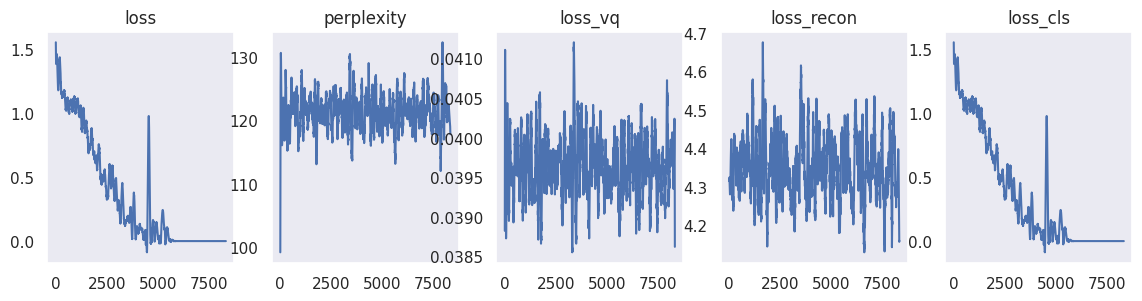

In [30]:
from scipy.signal import savgol_filter

fig, axes = plt.subplots(1, 5, figsize=(14,3))
for i, c in enumerate(loss_df.columns):
    axes[i].plot(savgol_filter(loss_df[c], 301, 7))
    axes[i].set_title(c)

In [9]:
from einops import reduce, repeat, rearrange

In [39]:
train_losses = reduce(np.array(trainer.train_losses[:118*70]), '(n k) -> n', 'mean', n=70)

In [60]:
trainer.test_accuracy = [
    50/135, 
    72/135, 
    89/135,
    84/135, 
    92/135, 
    95/135, 
    95/135, 
    94/135
]

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

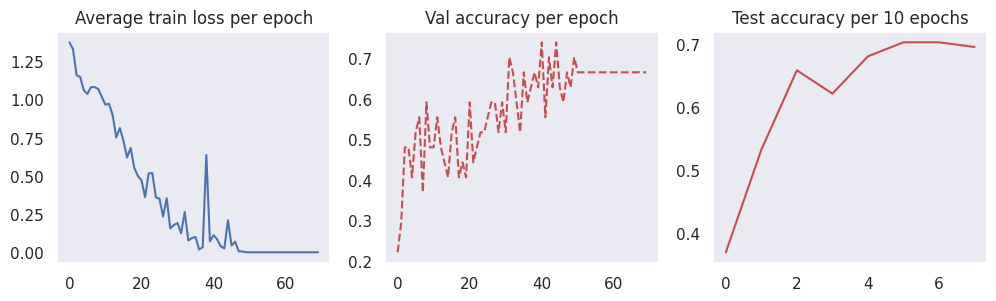

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

<Axes: xlabel='Predicted', ylabel='Actual'>

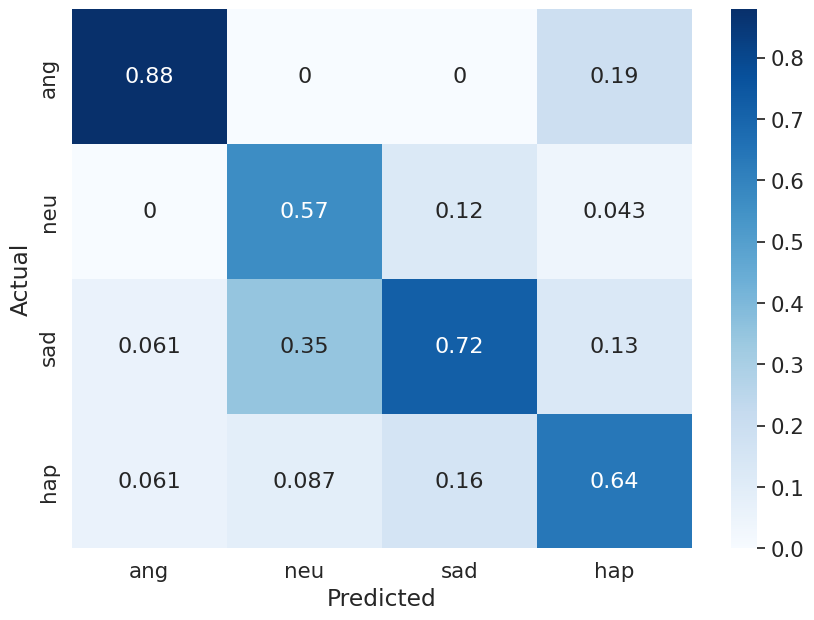

In [68]:
labels = dataset_config.target_labels
a = torch.tensor(
    [[29,  0,  0,  9],
        [ 0, 13,  4,  2],
        [ 2,  8, 23,  6],
        [ 2,  2,  5, 30]], dtype=torch.float)
# a /= reduce(a, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels )
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

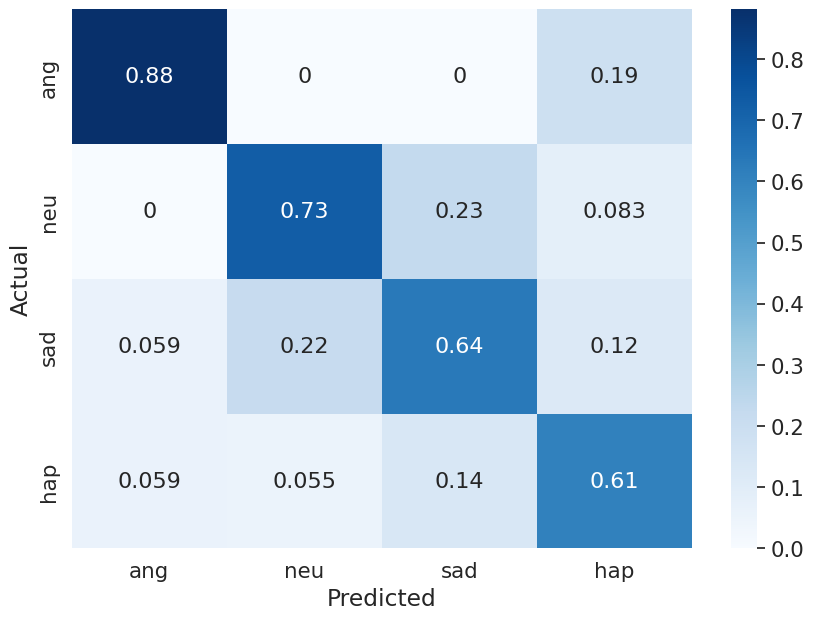

In [69]:
labels = dataset_config.target_labels
a = torch.tensor(
    [[29,  0,  0,  9],
        [ 0, 13,  4,  2],
        [ 2,  8, 23,  6],
        [ 2,  2,  5, 30]], dtype=torch.float)
a /= reduce(a, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels )
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [72]:
loss_df.to_csv(log_dir+"train_losses.csv")

In [73]:
dataset_name = 'meld'
experiment_prefix = "scb14"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"


In [74]:
dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

{'name': 'meld', 'dataset_class': 'WaveformDataset', 'root': 'meld/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 4, 'label_values': ['neu', 'hap', 'sad', 'ang'], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [75]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0, loss_recon=0, loss_cls=1)

trainer.log_dir = log_dir
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [76]:
trainer.setup(model=model, lr=learning_rate)

In [77]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▏                           | 0.4768756423432689/100 [05:47<240:58:29, 8716.67s/it]

Epoch: 1	Loss: 1.313 [perplexity=47.431, loss_vq=0.036, loss_recon=5.722, loss_cls=1.313]	Val_acc: 54/184 (29.35%)

Saved new best val model: ../scb14_models/meld/model.epoch=1.step=406.loss=1.313.val_acc=0.293.pt


  1%|▎                           | 0.9527235354573254/100 [11:35<226:23:37, 8228.57s/it]

Epoch: 1	Loss: 1.252 [perplexity=58.796, loss_vq=0.039, loss_recon=4.369, loss_cls=1.252]	Val_acc: 56/184 (30.43%)

Saved new best val model: ../scb14_models/meld/model.epoch=1.step=811.loss=1.252.val_acc=0.304.pt


  1%|▍                               | 1.429599177800615/100 [14:26<9:42:30, 354.58s/it]

Correct: 264/928 (0.2845)
Saved new best test model: ../scb14_models/meld/model.epoch=1.step=811.test_acc=0.2845.pt
{'acc_unweighted': tensor(0.2575, device='cuda:0'),
 'acc_weighted': tensor(0.2845, device='cuda:0'),
 'f1s_unweighted': tensor(0.1868, device='cuda:0'),
 'f1s_weighted': tensor(0.2032, device='cuda:0'),
 'rocauc': tensor(0.5561, device='cuda:0'),
 'uar': tensor(0.2575, device='cuda:0'),
 'wap': tensor(0.3177, device='cuda:0')}
{'acc_detail': tensor([0.0155, 0.2702, 0.0124, 0.7318], device='cuda:0'),
 'f1s_detail': tensor([0.0291, 0.2991, 0.0242, 0.3946], device='cuda:0'),
 'precision_detail': tensor([0.2353, 0.3350, 0.5000, 0.2702], device='cuda:0'),
 'recall_detail': tensor([0.0155, 0.2702, 0.0124, 0.7318], device='cuda:0'),
 'rocauc_detail': tensor([0.6205, 0.5784, 0.5382, 0.4873], device='cuda:0')}
tensor([[  4,  34,   0, 220],
        [  2,  67,   2, 177],
        [  0,  40,   2, 119],
        [ 11,  59,   0, 191]], device='cuda:0')


  2%|▌                           | 1.9064748201439097/100 [20:18<233:09:37, 8556.91s/it]

Epoch: 2	Loss: 1.757 [perplexity=49.024, loss_vq=0.036, loss_recon=4.523, loss_cls=1.757]	Val_acc: 45/184 (24.46%)



  2%|▋                            | 2.382322713258016/100 [26:05<227:19:34, 8383.47s/it]

Epoch: 2	Loss: 1.380 [perplexity=18.170, loss_vq=0.025, loss_recon=5.727, loss_cls=1.380]	Val_acc: 60/184 (32.61%)

Saved new best val model: ../scb14_models/meld/model.epoch=2.step=1622.loss=1.380.val_acc=0.326.pt


  3%|▊                           | 2.8591983556013107/100 [31:59<226:35:50, 8397.61s/it]

Epoch: 3	Loss: 1.786 [perplexity=18.249, loss_vq=0.026, loss_recon=5.061, loss_cls=1.786]	Val_acc: 70/184 (38.04%)

Saved new best val model: ../scb14_models/meld/model.epoch=3.step=2028.loss=1.786.val_acc=0.380.pt


  3%|▉                           | 3.3350462487154173/100 [37:40<229:23:11, 8542.82s/it]

Epoch: 3	Loss: 1.398 [perplexity=29.871, loss_vq=0.029, loss_recon=3.783, loss_cls=1.398]	Val_acc: 54/184 (29.35%)



  4%|█                            | 3.811921891058712/100 [43:33<218:55:37, 8193.72s/it]

Epoch: 4	Loss: 1.295 [perplexity=122.960, loss_vq=0.049, loss_recon=2.863, loss_cls=1.295]	Val_acc: 51/184 (27.72%)



  4%|█▏                           | 4.287769784172694/100 [49:20<228:41:16, 8601.58s/it]

Epoch: 4	Loss: 1.215 [perplexity=27.231, loss_vq=0.029, loss_recon=6.151, loss_cls=1.215]	Val_acc: 60/184 (32.61%)



  5%|█▎                          | 4.7646454265157825/100 [55:08<218:29:06, 8258.97s/it]

Epoch: 5	Loss: 1.317 [perplexity=60.922, loss_vq=0.038, loss_recon=3.566, loss_cls=1.317]	Val_acc: 61/184 (33.15%)



  5%|█▎                        | 5.2404933196296835/100 [1:01:00<222:36:25, 8457.05s/it]

Epoch: 5	Loss: 1.130 [perplexity=30.487, loss_vq=0.033, loss_recon=6.977, loss_cls=1.130]	Val_acc: 61/184 (33.15%)



  6%|█▌                         | 5.717368961972772/100 [1:06:53<220:35:54, 8423.13s/it]

Epoch: 6	Loss: 1.118 [perplexity=75.646, loss_vq=0.041, loss_recon=2.786, loss_cls=1.118]	Val_acc: 66/184 (35.87%)



  6%|█▋                         | 6.193216855086673/100 [1:12:43<220:06:19, 8446.93s/it]

Epoch: 6	Loss: 1.475 [perplexity=12.730, loss_vq=0.022, loss_recon=4.469, loss_cls=1.475]	Val_acc: 60/184 (32.61%)



  7%|█▊                         | 6.670092497429762/100 [1:18:38<218:53:21, 8443.19s/it]

Epoch: 7	Loss: 1.484 [perplexity=82.568, loss_vq=0.044, loss_recon=3.195, loss_cls=1.484]	Val_acc: 67/184 (36.41%)



  7%|█▉                         | 7.145940390543663/100 [1:24:27<218:05:56, 8455.81s/it]

Epoch: 7	Loss: 1.204 [perplexity=62.520, loss_vq=0.040, loss_recon=2.155, loss_cls=1.204]	Val_acc: 73/184 (39.67%)

Saved new best val model: ../scb14_models/meld/model.epoch=7.step=5677.loss=1.204.val_acc=0.397.pt


  8%|██                         | 7.622816032886751/100 [1:30:18<217:10:38, 8463.55s/it]

Epoch: 8	Loss: 1.253 [perplexity=34.400, loss_vq=0.035, loss_recon=2.688, loss_cls=1.253]	Val_acc: 54/184 (29.35%)



  8%|██▏                        | 8.098663926000652/100 [1:36:04<217:35:15, 8523.44s/it]

Epoch: 8	Loss: 1.312 [perplexity=50.731, loss_vq=0.036, loss_recon=4.281, loss_cls=1.312]	Val_acc: 54/184 (29.35%)



  9%|██▎                        | 8.575539568343741/100 [1:41:56<215:41:51, 8493.48s/it]

Epoch: 9	Loss: 1.289 [perplexity=30.811, loss_vq=0.035, loss_recon=6.943, loss_cls=1.289]	Val_acc: 63/184 (34.24%)



  9%|██▍                        | 9.051387461457642/100 [1:47:44<211:59:58, 8391.53s/it]

Epoch: 9	Loss: 1.235 [perplexity=84.984, loss_vq=0.042, loss_recon=3.170, loss_cls=1.235]	Val_acc: 68/184 (36.96%)



 10%|██▋                         | 9.52826310380073/100 [1:53:33<211:13:32, 8404.97s/it]

Epoch: 10	Loss: 1.423 [perplexity=82.014, loss_vq=0.042, loss_recon=5.006, loss_cls=1.423]	Val_acc: 67/184 (36.41%)



 10%|██▌                       | 10.004110996914632/100 [1:59:24<207:38:35, 8306.11s/it]

Epoch: 10	Loss: 1.374 [perplexity=49.677, loss_vq=0.039, loss_recon=5.039, loss_cls=1.374]	Val_acc: 73/184 (39.67%)



 10%|██▊                        | 10.48098663925772/100 [2:05:11<211:36:03, 8509.51s/it]

Epoch: 11	Loss: 0.986 [perplexity=46.554, loss_vq=0.031, loss_recon=3.220, loss_cls=0.986]	Val_acc: 67/184 (36.41%)



 11%|██▊                       | 10.956834532371621/100 [2:11:05<211:28:16, 8549.75s/it]

Epoch: 11	Loss: 1.238 [perplexity=77.789, loss_vq=0.042, loss_recon=3.966, loss_cls=1.238]	Val_acc: 71/184 (38.59%)



 11%|███▍                          | 11.43371017471471/100 [2:14:00<9:07:59, 371.25s/it]

Correct: 336/928 (0.3621)
Saved new best test model: ../scb14_models/meld/model.epoch=11.step=8921.test_acc=0.3621.pt
{'acc_unweighted': tensor(0.3321, device='cuda:0'),
 'acc_weighted': tensor(0.3621, device='cuda:0'),
 'f1s_unweighted': tensor(0.2596, device='cuda:0'),
 'f1s_weighted': tensor(0.2831, device='cuda:0'),
 'rocauc': tensor(0.6008, device='cuda:0'),
 'uar': tensor(0.3321, device='cuda:0'),
 'wap': tensor(0.4725, device='cuda:0')}
{'acc_detail': tensor([0.6318, 0.6290, 0.0062, 0.0613], device='cuda:0'),
 'f1s_detail': tensor([0.4895, 0.4321, 0.0123, 0.1046], device='cuda:0'),
 'precision_detail': tensor([0.3995, 0.3291, 1.0000, 0.3556], device='cuda:0'),
 'recall_detail': tensor([0.6318, 0.6290, 0.0062, 0.0613], device='cuda:0'),
 'rocauc_detail': tensor([0.6753, 0.6013, 0.6085, 0.5181], device='cuda:0')}
tensor([[163,  87,   0,   8],
        [ 82, 156,   0,  10],
        [ 47, 102,   1,  11],
        [116, 129,   0,  16]], device='cuda:0')


 12%|███                       | 11.910585817057799/100 [2:19:55<215:07:04, 8791.34s/it]

Epoch: 12	Loss: 1.088 [perplexity=164.662, loss_vq=0.057, loss_recon=2.669, loss_cls=1.088]	Val_acc: 54/184 (29.35%)



 12%|███▍                        | 12.3864337101717/100 [2:25:59<210:44:44, 8659.44s/it]

Epoch: 12	Loss: 1.151 [perplexity=30.021, loss_vq=0.033, loss_recon=4.466, loss_cls=1.151]	Val_acc: 67/184 (36.41%)



 13%|███▎                      | 12.863309352514788/100 [2:32:13<212:50:24, 8793.36s/it]

Epoch: 13	Loss: 1.498 [perplexity=62.353, loss_vq=0.041, loss_recon=3.409, loss_cls=1.498]	Val_acc: 72/184 (39.13%)



 13%|███▍                      | 13.339157245628689/100 [2:38:23<217:40:20, 9042.38s/it]

Epoch: 13	Loss: 1.281 [perplexity=62.579, loss_vq=0.039, loss_recon=6.307, loss_cls=1.281]	Val_acc: 67/184 (36.41%)



 14%|███▌                      | 13.816032887971778/100 [2:44:33<206:58:54, 8645.85s/it]

Epoch: 14	Loss: 1.230 [perplexity=76.481, loss_vq=0.043, loss_recon=3.566, loss_cls=1.230]	Val_acc: 56/184 (30.43%)



 14%|███▋                      | 14.291880781085679/100 [2:50:32<202:29:25, 8505.21s/it]

Epoch: 14	Loss: 0.912 [perplexity=45.924, loss_vq=0.037, loss_recon=3.281, loss_cls=0.912]	Val_acc: 64/184 (34.78%)



 15%|███▊                      | 14.768756423428767/100 [2:56:27<200:37:58, 8474.34s/it]

Epoch: 15	Loss: 0.945 [perplexity=44.633, loss_vq=0.036, loss_recon=4.569, loss_cls=0.945]	Val_acc: 62/184 (33.70%)



 15%|███▉                      | 15.244604316542668/100 [3:02:19<203:32:07, 8645.21s/it]

Epoch: 15	Loss: 0.751 [perplexity=37.034, loss_vq=0.033, loss_recon=4.615, loss_cls=0.751]	Val_acc: 58/184 (31.52%)



 16%|████                      | 15.721479958885757/100 [3:08:24<200:32:34, 8566.30s/it]

Epoch: 16	Loss: 0.670 [perplexity=48.544, loss_vq=0.033, loss_recon=4.110, loss_cls=0.670]	Val_acc: 63/184 (34.24%)



 16%|████▎                      | 16.19732785199966/100 [3:14:15<202:11:59, 8686.12s/it]

Epoch: 16	Loss: 1.693 [perplexity=50.742, loss_vq=0.038, loss_recon=5.203, loss_cls=1.693]	Val_acc: 59/184 (32.07%)



 17%|████▌                      | 16.67420349434275/100 [3:20:11<199:55:33, 8637.58s/it]

Epoch: 17	Loss: 0.341 [perplexity=35.052, loss_vq=0.033, loss_recon=3.708, loss_cls=0.341]	Val_acc: 54/184 (29.35%)



 17%|████▋                       | 16.938335046243985/100 [3:23:13<16:13:38, 703.31s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdb32471070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdb32471070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 17%|████▋                       | 16.938335046243985/100 [3:23:14<16:36:37, 719.91s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1339058/358793349.py", line 1, in <module>
    trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)
  File "/home/linh/projects/IConNet/IConNet/trainer/train_torch.py", line 391, in fit
    for epoch in range(n_epoch):
  File "/home/linh/projects/IConNet/IConNet/trainer/train_torch.py", line 193, in train_step
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceba

In [9]:
# iconnet_config.fe.n_channel = [256]
# iconnet_config.fe.mel_resolution = 4
# iconnet_config.cls.n_hidden_dim = 512, 512
# iconnet_config.cls.dropout = 0.1
# print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 4, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


In [8]:
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=512,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='minami',
    iconnet_config=iconnet_config,
)

In [9]:
dataset_name = 'crema_d'
experiment_prefix = "scb14"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
batch_size = 2

{'name': 'crema_d', 'dataset_class': 'WaveformDataset', 'root': 'crema_d/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label6', 'feature_name': 'audio16k', 'num_classes': 6, 'label_values': ['neu', 'hap', 'sad', 'ang', 'fea', 'dis'], 'classnames': ['neu', 'hap', 'sad', 'ang', 'fea', 'dis'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [10]:
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

In [11]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=0.1)
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [12]:
trainer.setup(model=model, lr=learning_rate)

In [ ]:
trainer.fit(
    n_epoch=500, lr=learning_rate, self_supervised=False, 
    train_task='embedding', test_n_epoch=10)

  0%|                         | 0.47667638483965535/500 [05:33<3127:35:43, 22540.18s/it]

Epoch: 1	Loss: 6.323 [perplexity=129.756, loss_vq=0.059, loss_recon=6.173, loss_cls=0.909]	Val_acc: 119/196 (60.71%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=1.step=858.loss=6.323.val_acc=0.607.pt


  0%|                               | 1.428571428571466/500 [14:34<71:45:25, 518.13s/it]

Correct: 392/980 (0.4000)
Saved new best test model: ../scb14_models/crema_d/model.epoch=1.step=1715.test_acc=0.4000.pt
{'acc_unweighted': tensor(0.4209, device='cuda:0'),
 'acc_weighted': tensor(0.4000, device='cuda:0'),
 'f1s_unweighted': tensor(0.2863, device='cuda:0'),
 'f1s_weighted': tensor(0.2799, device='cuda:0'),
 'rocauc': tensor(0.8065, device='cuda:0'),
 'uar': tensor(0.4209, device='cuda:0'),
 'wap': tensor(0.2422, device='cuda:0')}
{'acc_detail': tensor([0.6929, 0.9908, 0.0000, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.6848, 0.4606, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.6769, 0.3000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.6929, 0.9908, 0.0000, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.9053, 0.7174, 0.9043, 0.6988], device='cuda:0')}
tensor([[176,  78,   0,   0],
        [  2, 216,   0,   0],
        [  2, 252,   0,   0],
        [ 80, 174,   0,   0]], device='cuda:0')


  0%|                          | 1.9052478134111321/500 [20:13<3120:52:49, 22556.29s/it]

Epoch: 2	Loss: 5.935 [perplexity=119.540, loss_vq=0.056, loss_recon=5.786, loss_cls=0.927]	Val_acc: 125/196 (63.78%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=2.step=2573.loss=5.935.val_acc=0.638.pt


  0%|▏                             | 2.4995140913508993/500 [26:29<88:39:11, 641.51s/it]